<a href="https://colab.research.google.com/github/sibat119/pytorch-intro/blob/main/nn_using_gpu_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

image.shape: torch.Size([1, 28, 28])
Label: 5


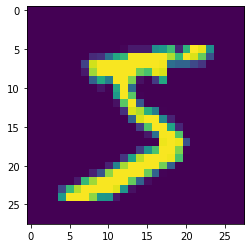

In [3]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image[0])
print('Label:', label)

In [4]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [5]:
batch_size=128

In [6]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Can you figure out the purpose of the arguments `num_workers` and `pin_memory`? Try looking into the documentation: https://pytorch.org/docs/stable/data.html .

Let's visualize a batch of data in a grid using the `make_grid` function from `torchvision`. We'll also use the `.permute` method on the tensor to move the channels to the last dimension, as expected by `matplotlib`.


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 1, 28, 28])


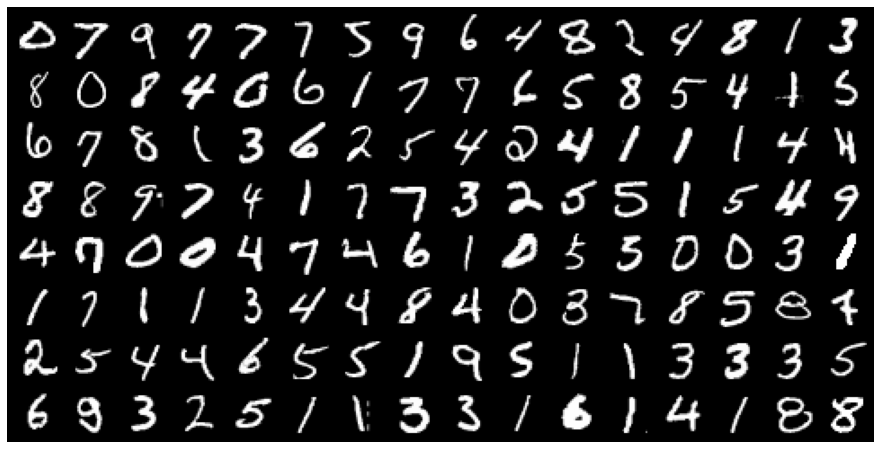

In [7]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Hidden Layers, Activation Functions and Non-Linearity

We'll create a neural network with two layers: a _hidden layer_ and an _output layer_. Additionally, we'll use an _activation function_ between the two layers. Let's look at a step-by-step example to learn how hidden layers and activation functions can help capture non-linear relationships between inputs and outputs.

First, let's create a batch of inputs tensors. We'll flatten the `1x28x28` images into vectors of size `784`, so they can be passed into an `nn.Linear` object.

In [8]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape:', inputs.shape)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


In [9]:
input_size = inputs.shape[-1]
hidden_size = 32

In [10]:
layer1 = nn.Linear(input_size, hidden_size)

In [11]:
inputs.shape

torch.Size([128, 784])

In [12]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 32])


In [13]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [14]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

In [15]:
?torch.allclose

Thus, `layer1_outputs` and `inputs` have a linear relationship, i.e., each element of `layer_outputs` is a weighted sum of elements from `inputs`. Thus, even as we train the model and modify the weights, `layer1` can only capture linear relationships between `inputs` and `outputs`.

<img src="https://i.imgur.com/inXsLuq.png" width="360">

Next, we'll use the Rectified Linear Unit (ReLU) function as the activation function for the outputs. It has the formula `relu(x) = max(0,x)` i.e. it simply replaces negative values in a given tensor with the value 0. ReLU is a non-linear function, as seen here visually:

<img src="https://i.imgur.com/yijV4xF.png" width="420">

We can use the `F.relu` method to apply ReLU to the elements of a tensor.

In [16]:
F.relu(torch.tensor([[1, -1, 0], 
                     [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

In [17]:
relu_outputs = F.relu(layer1_outputs)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

min(layer1_outputs): -0.9481135606765747
min(relu_outputs): 0.0


Now that we've applied a non-linear activation function, `relu_outputs` and `inputs` do not have a linear relationship. We refer to `ReLU` as the _activation function_, because for each input certain outputs are activated (those with non-zero values) while others turned off (those with zero values)

Next, let's create an output layer to convert vectors of length `hidden_size` in `relu_outputs` into vectors of length 10, which is the desired output of our model (since there are 10 target labels).

In [18]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

In [19]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [20]:
inputs.shape

torch.Size([128, 784])

In [21]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.3138, grad_fn=<NllLossBackward>)

Thus, our model transforms `inputs` into `layer2_outputs` by applying a linear transformation (using `layer1`), followed by a non-linear activation (using `F.relu`), followed by another linear transformation (using `layer2`). Let's verify this by re-computing the output using basic matrix operations.

In [22]:
# Expanded version of layer2(F.relu(layer1(inputs)))
outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias

In [23]:
torch.allclose(outputs, layer2_outputs, 1e-3)

True

Note that `outputs` and `inputs` do not have a linear relationship due to the non-linear activation function `F.relu`. As we train the model and adjust the weights of `layer1` and `layer2`, we can now capture non-linear relationships between the images and their labels. In other words, introducing non-linearity makes the model more powerful and versatile. Also, since `hidden_size` does not depend on the dimensions of the inputs or outputs, we vary it to increase the number of parameters within the model. We can also introduce new hidden layers and apply the same non-linear activation after each hidden layer.

The model we just created is called a neural network. A _deep neural network_ is simply a neural network with one or more hidden layers. In fact, the [Universal Approximation Theorem](http://neuralnetworksanddeeplearning.com/chap4.html) states that a sufficiently large & deep neural network can compute any arbitrary function i.e. it can _learn_ rich and complex non-linear relationships between inputs and targets. Here are some examples:

* Identifying if an image contains a cat or a dog (or [something else](https://machinelearningmastery.com/introduction-to-the-imagenet-large-scale-visual-recognition-challenge-ilsvrc/))
* Identifying the genre of a song using a 10-second sample
* Classifying movie reviews as positive or negative based on their content
* Navigating self-driving cars using a video feed of the road
* Translating sentences from English to French (and hundreds of other languages)
* Converting a speech recording to text and vice versa
* And many more...

It's hard to imagine how the simple process of multiplying inputs with randomly initialized matrices, applying non-linear activations, and adjusting weights repeatedly using gradient descent can yield such astounding results. Deep learning models often contain millions of parameters, which can together capture far more complex relationships than the human brain can comprehend.

If we hadn't included a non-linear activation between the two linear layers, the final relationship between inputs and outputs would still be linear. A simple refactoring of the computations illustrates this.

In [24]:
# Same as layer2(layer1(inputs))
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

In [25]:
# Create a single layer to replace the two linear layers
combined_layer = nn.Linear(input_size, output_size)

combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

In [26]:
# Same as combined_layer(inputs)
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

In [27]:
torch.allclose(outputs2, outputs3, 1e-3)

False

## Model

We are now ready to define our model. As discussed above, we'll create a neural network with one hidden layer. Here's what that means:

* Instead of using a single `nn.Linear` object to transform a batch of inputs (pixel intensities) into outputs (class probabilities), we'll use two `nn.Linear` objects. Each of these is called a _layer_ in the network. 

* The first layer (also known as the hidden layer) will transform the input matrix of shape `batch_size x 784` into an intermediate output matrix of shape `batch_size x hidden_size`. The parameter `hidden_size` can be configured manually (e.g., 32 or 64).

* We'll then apply a non-linear *activation function* to the intermediate outputs. The activation function transforms individual elements of the matrix.

* The result of the activation function, which is also of size `batch_size x hidden_size`, is passed into the second layer (also known as the output layer).  The second layer transforms it into a matrix of size `batch_size x 10`. We can use this output to compute the loss and adjust weights using gradient descent.


As discussed above, our model will contain one hidden layer. Here's what it looks like visually:

<img src="https://i.imgur.com/eN7FrpF.png" width="480">


Let's define the model by extending the `nn.Module` class from PyTorch.

In [28]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [29]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [30]:
input_size = 784
hidden_size = 64 # you can change this
num_classes = 10

In [31]:
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)

In [32]:
for t in model.parameters():
    print(t.t().shape)

torch.Size([784, 64])
torch.Size([64])
torch.Size([64, 10])
torch.Size([10])


In [33]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Loss: 2.3440699577331543
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[-0.0221, -0.1181, -0.1043, -0.0077, -0.1372,  0.2079, -0.0155,  0.0286,
         -0.1293,  0.1289],
        [-0.0213, -0.1363, -0.0632,  0.0219, -0.1178,  0.2319,  0.0201, -0.0338,
         -0.0661,  0.0794]])


## Using a GPU

As the sizes of our models and datasets increase, we need to use GPUs to train our models within a reasonable amount of time. GPUs contain hundreds of cores optimized for performing expensive matrix operations on floating-point numbers quickly, making them ideal for training deep neural networks. You can use GPUs for free on [Google Colab](https://colab.research.google.com/) and [Kaggle](https://www.kaggle.com/kernels) or rent GPU-powered machines on services like [Google Cloud Platform](https://cloud.google.com/gpu/), [Amazon Web Services](https://docs.aws.amazon.com/dlami/latest/devguide/gpu.html), and [Paperspace](https://www.paperspace.com/).

We can check if a GPU is available and the required NVIDIA CUDA drivers are installed using `torch.cuda.is_available`.

In [34]:
torch.cuda.is_available()

True

Let's define a helper function to ensure that our code uses the GPU if available and defaults to using the CPU if it isn't. 

In [35]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [36]:
device = get_default_device()
device

device(type='cuda')

In [37]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [38]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
cuda:0


Finally, we define a `DeviceDataLoader` class to wrap our existing data loaders and move batches of data to the selected device. Interestingly, we don't need to extend an existing class to create a PyTorch datal oader. All we need is an `__iter__` method to retrieve batches of data and an `__len__` method to get the number of batches.

In [39]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

The `yield` keyword in Python is used to create a generator function that can be used within a `for` loop, as illustrated below.

In [40]:
def some_numbers():
    yield 10
    yield 20
    yield 30

for value in some_numbers():
    print(value)

10
20
30


In [41]:
#We can now wrap our data loaders using DeviceDataLoader.
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

Tensors moved to the GPU have a `device` property which includes that word `cuda`. Let's verify this by looking at a batch of data from `valid_dl`.

In [42]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


xb.device: cuda:0
yb: tensor([9, 7, 8, 6, 4, 7, 9, 1, 2, 9, 0, 7, 4, 4, 4, 9, 7, 3, 0, 0, 1, 5, 1, 9,
        5, 2, 6, 1, 5, 9, 8, 1, 0, 3, 1, 1, 1, 8, 3, 6, 0, 1, 5, 2, 7, 3, 8, 8,
        4, 7, 0, 0, 0, 8, 3, 5, 1, 1, 6, 0, 9, 0, 9, 8, 0, 1, 2, 6, 1, 2, 6, 7,
        3, 0, 4, 0, 8, 0, 5, 0, 7, 8, 6, 8, 6, 8, 1, 0, 4, 5, 9, 1, 5, 2, 8, 4,
        8, 6, 0, 1, 7, 4, 7, 4, 7, 6, 8, 2, 4, 2, 2, 3, 0, 7, 6, 5, 5, 6, 0, 3,
        4, 8, 9, 3, 1, 1, 3, 2, 0, 6, 7, 0, 3, 6, 2, 9, 9, 5, 7, 3, 8, 0, 8, 6,
        6, 8, 5, 7, 0, 1, 7, 2, 9, 5, 0, 7, 5, 4, 8, 5, 0, 7, 2, 3, 1, 6, 6, 4,
        3, 1, 0, 7, 5, 7, 1, 9, 2, 3, 6, 2, 5, 3, 6, 1, 6, 9, 0, 5, 2, 9, 8, 0,
        4, 4, 8, 6, 3, 8, 5, 0, 4, 5, 7, 7, 6, 3, 9, 1, 5, 8, 5, 3, 3, 8, 6, 4,
        0, 3, 1, 8, 7, 0, 7, 6, 3, 6, 6, 1, 4, 2, 8, 0, 4, 4, 4, 9, 8, 5, 7, 3,
        0, 0, 6, 4, 1, 0, 8, 9, 1, 7, 6, 5, 7, 6, 2, 9], device='cuda:0')


## Training the Model

We'll define two functions: `fit` and `evaluate` to train the model using gradient descent and evaluate its performance on the validation set. 

In [43]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Before we train the model, we need to ensure that the data and the model's parameters (weights and biases) are on the same device (CPU or GPU). We can reuse the `to_device` function to move the model's parameters to the right device. 

In [44]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=10, bias=True)
)

Let's see how the model performs on the validation set with the initial set of weights and biases.

In [45]:
history = [evaluate(model, val_loader)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.14267578721046448, 'val_loss': 2.2964260578155518}]

The initial accuracy is around 10%, as one might expect from a randomly initialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly).

Let's train the model for five epochs and look at the results. We can use a relatively high learning rate of 0.5.

In [46]:
history += fit(5, 0.5, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 0.2222, val_acc: 0.9334
Epoch [1], val_loss: 0.1570, val_acc: 0.9543
Epoch [2], val_loss: 0.1196, val_acc: 0.9650
Epoch [3], val_loss: 0.1136, val_acc: 0.9669
Epoch [4], val_loss: 0.1023, val_acc: 0.9707


96% is pretty good! Let's train the model for five more epochs at a lower learning rate of 0.1 to improve the accuracy further.

In [47]:
history += fit(5, 0.1, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 0.0942, val_acc: 0.9720
Epoch [1], val_loss: 0.0918, val_acc: 0.9723
Epoch [2], val_loss: 0.0917, val_acc: 0.9724
Epoch [3], val_loss: 0.0901, val_acc: 0.9730
Epoch [4], val_loss: 0.0898, val_acc: 0.9731


In [48]:
history += fit(5, 0.01, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 0.0885, val_acc: 0.9731
Epoch [1], val_loss: 0.0881, val_acc: 0.9731
Epoch [2], val_loss: 0.0881, val_acc: 0.9729
Epoch [3], val_loss: 0.0882, val_acc: 0.9727
Epoch [4], val_loss: 0.0882, val_acc: 0.9729


In [49]:
history += fit(5, 0.0001, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 0.0882, val_acc: 0.9729
Epoch [1], val_loss: 0.0882, val_acc: 0.9728
Epoch [2], val_loss: 0.0882, val_acc: 0.9727
Epoch [3], val_loss: 0.0882, val_acc: 0.9727
Epoch [4], val_loss: 0.0882, val_acc: 0.9728


We can now plot the losses & accuracies to study how the model improves over time.

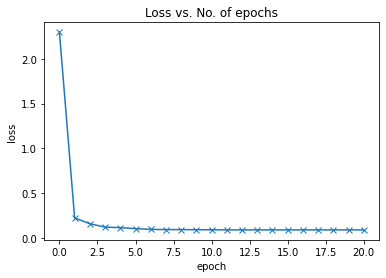

In [50]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

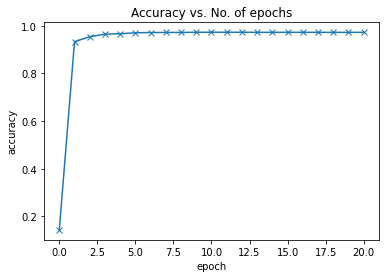

In [51]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

## Testing with individual images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images. We begin by recreating the test dataset with the `ToTensor` transform.

In [52]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

In [53]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


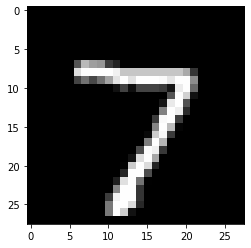

In [54]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 2


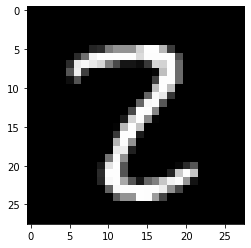

In [55]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

As a final step, let's also look at the overall loss and accuracy of the model on the test set.

In [56]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.9754883050918579, 'val_loss': 0.07989182323217392}